## CS4287 - Neural Network
### Assignment 1 - 4th Year Semester 1 2024

Adam Collins: 21332967

Italo da Silva: 21326312

The Code executes to the end without an error. 

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [2]:
housing_data = pd.read_csv('Melbourne_housing_FULL.csv')
columns = ["Suburb","Rooms","Type","Price","Method","SellerG","Date","Distance","Bedroom2","Bathroom","Car","Landsize","BuildingArea","YearBuilt","CouncilArea","Lattitude","Longtitude","Regionname","Propertycount"]
housing_data = housing_data.dropna(subset=columns)
housing_data.drop(["Suburb", "Address", "Type", "Method", "SellerG", "CouncilArea", "Regionname", "Date"], inplace=True, axis="columns")
housing_data.head()

/var/folders/1j/mj6gkgvj7qgfv79ksrtpvb5h0000gn/T/ipykernel_858/2284233341.py:1: DtypeWarning: Columns (2,4,8,9,10,11,12,13,14,15,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  housing_data = pd.read_csv('Melbourne_housing_FULL.csv')


,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
2,2,1035000.0,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,4019.0
4,3,1465000.0,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,4019.0
6,4,1600000.0,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,-37.8072,144.9941,4019.0
11,3,1876000.0,2.5,3067.0,4.0,2.0,0.0,245.0,210.0,1910.0,-37.8024,144.9993,4019.0
14,2,1636000.0,2.5,3067.0,2.0,1.0,2.0,256.0,107.0,1890.0,-37.806,144.9954,4019.0


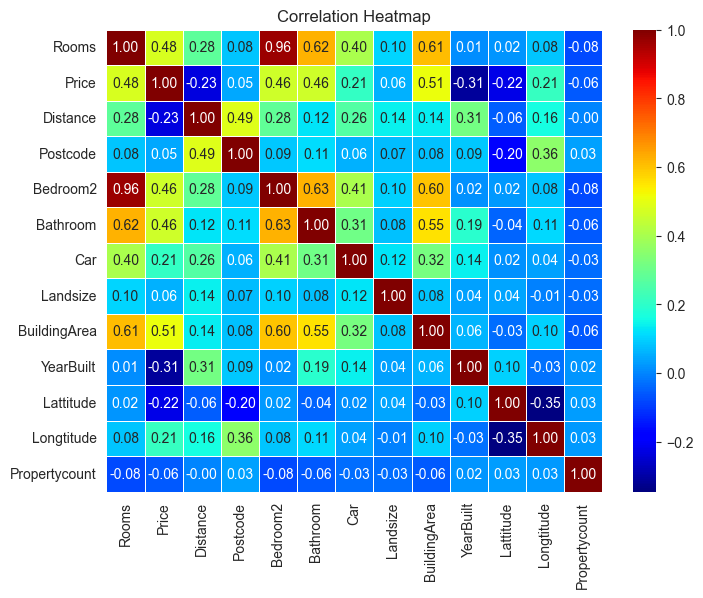

In [3]:
# Dataframe of key attributes
housing_data.corr()

# Correlation matrix
corr_matrix = housing_data.corr()

# Generate Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='jet', cbar=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

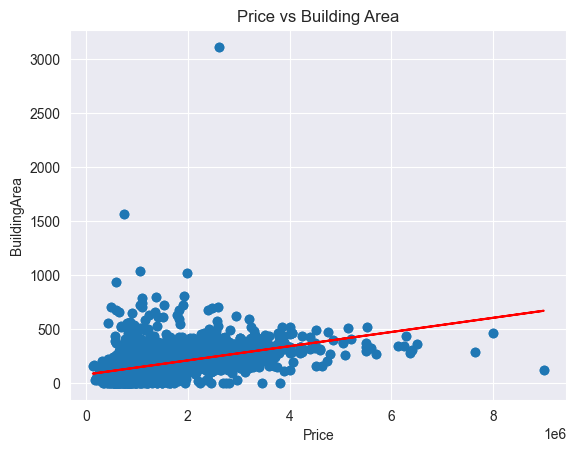

In [12]:
# Draw graph of correlation between Price and Building Area
price = housing_data['Price'].values.reshape(-1,1)
building_area = housing_data['BuildingArea'].values.reshape(-1,1)

reg = LinearRegression().fit(price, building_area)

plt.plot(housing_data.Price, housing_data.BuildingArea, 'o')
plt.plot(housing_data.Price, reg.predict(price), 'r')
plt.xlabel('Price')
plt.ylabel('BuildingArea')
plt.title('Price vs Building Area')
plt.show()